In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from util.bilrc_util import read_ns1_data, logtime_r2
from util.fitting import fit_multi_exponential, eval_exp_fit

In [2]:
# Load data from binary files
T_neg, Y_neg = read_ns1_data('data/030722_s1_RTDP_alone_2.ns1')
T_pyo50, Y_pyo50 = read_ns1_data('data/030722_s2_RTDP_50uMPYO_1.ns1')
T_pyo500, Y_pyo500 = read_ns1_data('data/030722_s3_RTDP_500uMPYO_1.ns1')

In [3]:
# Resample for logarithmically-spaced timepoints: simplifies manipulations
# and allows fair fitting of multi-exponential processes
t_neg_re, y_neg_re, wts_neg = logtime_r2(T_neg, Y_neg, 100)
t_pyo50_re, y_pyo50_re, wts_pyo50 = logtime_r2(T_pyo50, Y_pyo50, 100)
t_pyo500_re, y_pyo500_re, wts_pyo500 = logtime_r2(T_pyo500, Y_pyo500, 100)

In [4]:
def _blank_ys(ys):
    # Assuming the ys contain pre-shot data, we can 
    # use the mean of the first 10 timepoints as a baseline.
    return ys - ys[10].mean()

Prefactors (AU): [  1.20801269 163.51561453]
Exponents (us^-1): [1.85486215 1.97174101]

Prefactors (AU): [114.26858248   1.65709551]
Exponents (us^-1): [1.8867322  1.82009934]

Prefactors (AU): [21.44400163 29.36033821]
Exponents (us^-1): [  3.13669863 159.1168099 ]



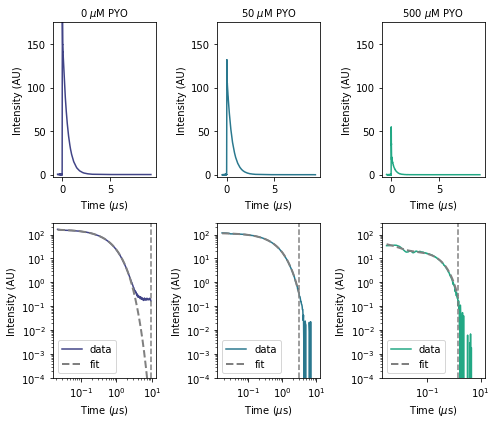

In [5]:
sample_data = [(t_neg_re, _blank_ys(y_neg_re)),
               (t_pyo50_re, _blank_ys(y_pyo50_re)), 
               (t_pyo500_re, _blank_ys(y_pyo500_re))]
sample_names = '0 $\mu$M PYO,50 $\mu$M PYO,500 $\mu$M PYO'.split(',')

fig, axs = plt.subplots(figsize=(7,6), ncols=3, nrows=2)
pal = sns.color_palette('viridis', n_colors=4)
for i, sname in enumerate(sample_names):
    ts, ys_blanked = sample_data[i]
    ax = axs[0,i]
    plt.sca(ax)
    
    plt.plot(ts*1e6, ys_blanked, color=pal[i])
    plt.ylabel('Intensity (AU)')
    plt.xlabel('Time ($\mu$s)')
    plt.title(sname, fontsize=10)
    plt.ylim(-3, 175)
    
for i, sname in enumerate(sample_names):
    ts, ys_blanked = sample_data[i]
    ax = axs[1,i]
    plt.sca(ax)
    
    # Start a little after the maximum intensity
    start_idx = ys_blanked.argmax() + 10
    
    # Endpoint is chosen as either the end of the data or the 
    # point where a windowed std-dev exceeds 25% of the mean.
    y_series = pd.Series(ys_blanked[start_idx:])
    t_series = pd.Series(ts[start_idx:])
    rolling_CV = y_series.rolling(5).std()
    rolling_CV /= y_series.rolling(5).mean()
    rolling_t = t_series.rolling(5).mean()
    mask = np.abs(rolling_CV) > 0.25
    if mask.any():
        end_idx = np.where(mask)[0][0]
        tend = rolling_t[end_idx]
    else:
        end_idx = t_series.size - 1
        tend = t_series.values[-1]
    
    fitting_ts = ts[start_idx:start_idx+end_idx]
    fitting_ys = ys_blanked[start_idx:start_idx+end_idx]
    
    # Fit a 2-exponential process for now. 
    # 
    prefactors, exps, red_chi_sq = fit_multi_exponential(
        2, fitting_ts, fitting_ys)
    pred_ys = eval_exp_fit(fitting_ts, prefactors, exps)
    print('Prefactors (AU):', prefactors)
    print('Exponents (us^-1):', exps * 1e-6)
    print()

    plt.loglog(t_series*1e6, y_series, color=pal[i], label='data')
    plt.loglog(fitting_ts*1e6, pred_ys, color='grey', ls='--', lw=2, label='fit')
    plt.axvline(tend*1e6, color='grey', ls='--')

    plt.legend()
    plt.ylabel('Intensity (AU)')
    plt.xlabel('Time ($\mu$s)')
    plt.ylim(1e-4, 3e2)
    
plt.tight_layout()
plt.savefig('/Users/flamholz/Desktop/030822_fitting_multi_exp.png', facecolor='w',
            dpi=600)
plt.show()
